# KMeans from Scratch

```yaml
Course:   DS 5001
Module:   06 Lab
Topic:    KMeans Clustering
Author:   R.C.Alvarado
Date:     21 February 2024
```

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [3]:
from string import ascii_uppercase as letters
from scipy.spatial.distance import pdist

# Prepare Data

## Get Data IRIS

In [4]:
IRIS = sns.load_dataset('iris')
IRIS.index.name = 'obs_id'

In [5]:
IRIS.head()

,sepal_length,sepal_width,petal_length,petal_width,species
obs_id,,,,,
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


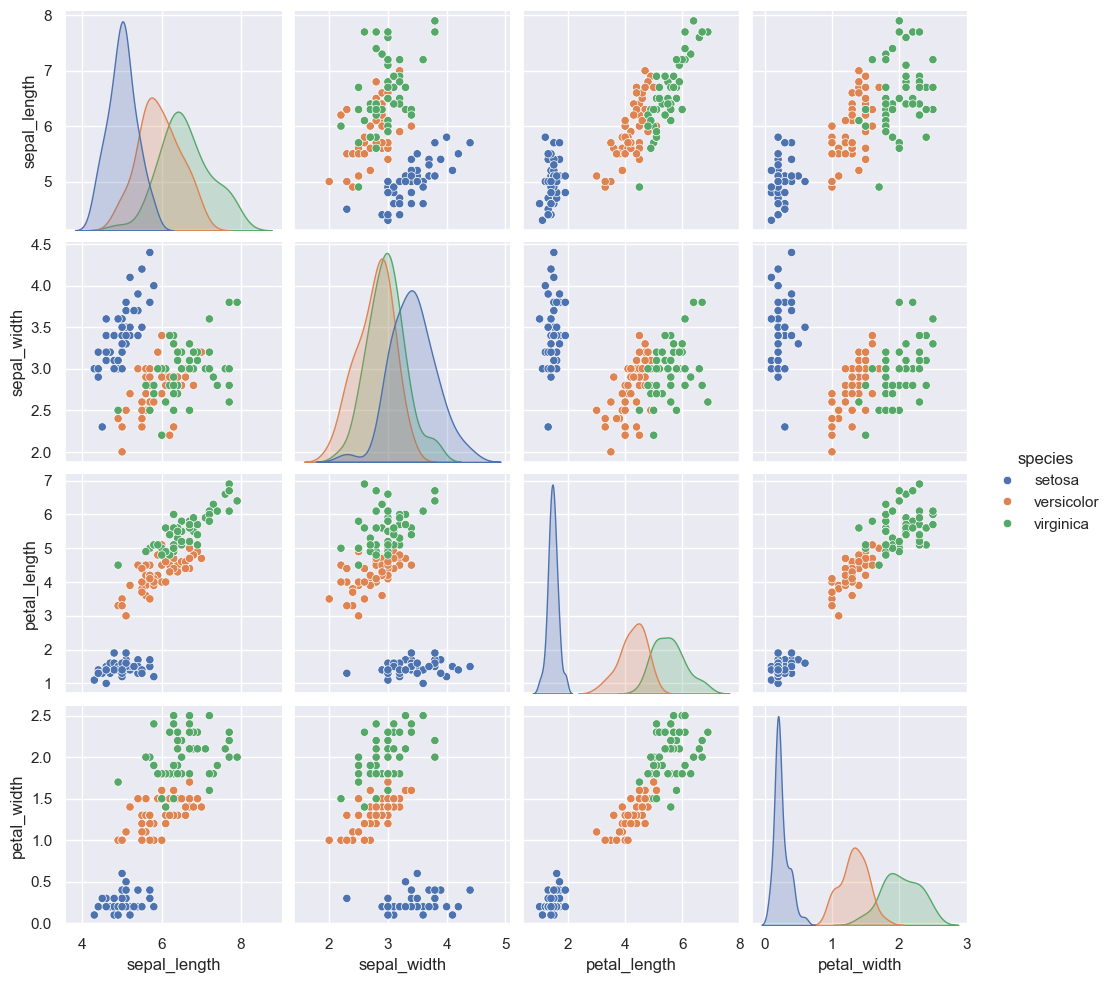

In [6]:
sns.pairplot(IRIS, hue='species');

## Extract SPECIES

In [7]:
SPECIES = IRIS.groupby('species').mean()

In [8]:
SPECIES.style.background_gradient()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006000,3.428000,1.462000,0.246000
versicolor,5.936000,2.770000,4.260000,1.326000
virginica,6.588000,2.974000,5.552000,2.026000


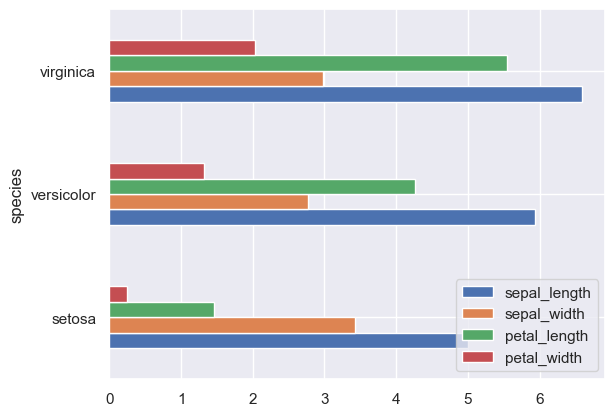

In [9]:
SPECIES.plot.barh();

In [10]:
IRIS2 = IRIS.iloc[:,:-1] # Remove the labels

# Model

## Define parameters

In [11]:
k = 3
max_iterations = 100
d_metric = 'jensenshannon'
# d_metric = 'canberra'
# d_metric = 'cityblock'
# d_metric = 'euclidean'
# d_metric = 'jaccard'

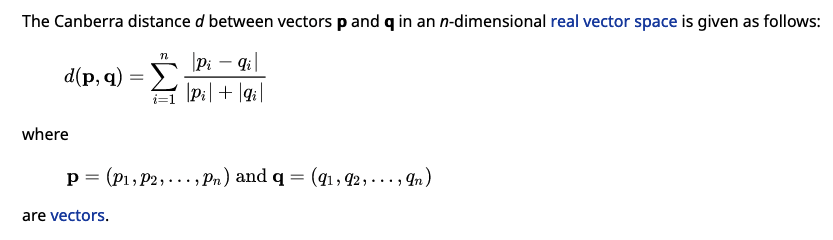
[Source](https://www.wikiwand.com/en/Canberra_distance)

## Prepare tables

In [12]:
def KMeans(X, k=2, d_metric='euclidean'):
    
    # Randomly pick k CENTROIDS from the data
    CENTROIDS = X.sample(k)
    CENTROIDS.index.name = 'cat_id'

    # Give them alphabetic names
    CENTROIDS.index = list(letters)[:k]

    # Create table to store distances from centroids
    DISTANCES = pd.DataFrame(index=pd.MultiIndex.from_product([CENTROIDS.index, X.index]))
    DISTANCES.index.names = ['cat_id', 'obs_id']

    # Iterate until convergence
    progress = []
    for i in range(max_iterations):

        # Get distances
        for obs_id in X.index:
            for cat_id in CENTROIDS.index:
                d = pdist(pd.concat([X.loc[obs_id], CENTROIDS.loc[cat_id]], axis=1).T, d_metric)[0]
                DISTANCES.loc[(cat_id, obs_id), 'dist'] = d

        # Get min distances
        CLUSTERS = DISTANCES.unstack().idxmin().to_frame('cat')
        CLUSTERS.index = CLUSTERS.index.droplevel(0)

        # Get new Centroids
        NEW_CENTROIDS = CLUSTERS.join(X).groupby('cat').mean()

        # Test for convergence
        t = abs((CENTROIDS - NEW_CENTROIDS).sum().sum())

        # Update Centroids
        CENTROIDS = NEW_CENTROIDS

        progress.append(t)
        if t == 0:
            break
            
    return X.join(CLUSTERS), progress

In [13]:
R, progress = KMeans(IRIS2, 3, 'jensenshannon')

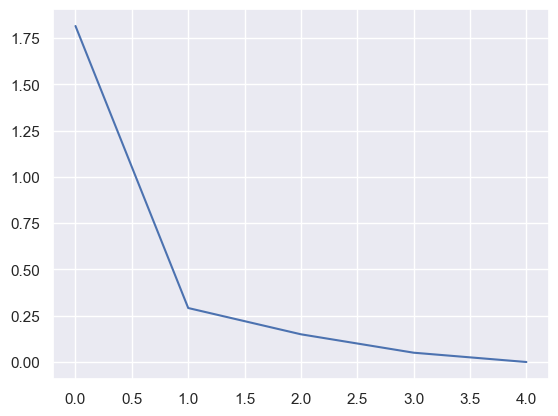

In [14]:
pd.Series(progress).plot();

# Evaluate

In [15]:
def evaluate(result, label_df, label_name='species'):
    
    # Combine results with labels
    X = result.join(label_df[label_name])
    
    # Get results per category in a confusion matrix
    M = X.value_counts(['cat', label_name])\
        .sort_index().to_frame().unstack(fill_value=0)
    M.columns = M.columns.droplevel(0)
    
    # Get entropy per category
    MP = (M.T + .0001) / (M.T + .0001).sum()
    MI = -np.log2(MP)
    MH = (MP * MI).sum()
    MH = np.round(MH, 2).sort_values()
    
    # Get redundancy as performance measure
    MR = np.round(1 - MH.mean() / np.log2(k), 2)
    
    return M, MH, MR
    

In [16]:
M, H, G = evaluate(R, IRIS, 'species')

In [17]:
M.T

cat,A,B,C
species,,,
setosa,50,0,0
versicolor,0,4,46
virginica,0,47,3


In [23]:
M.T.idxmax()

cat
A        setosa
B     virginica
C    versicolor
dtype: object

In [18]:
H

cat
A    0.00
C    0.33
B    0.40
dtype: float64

In [19]:
G

0.85

# Visualize

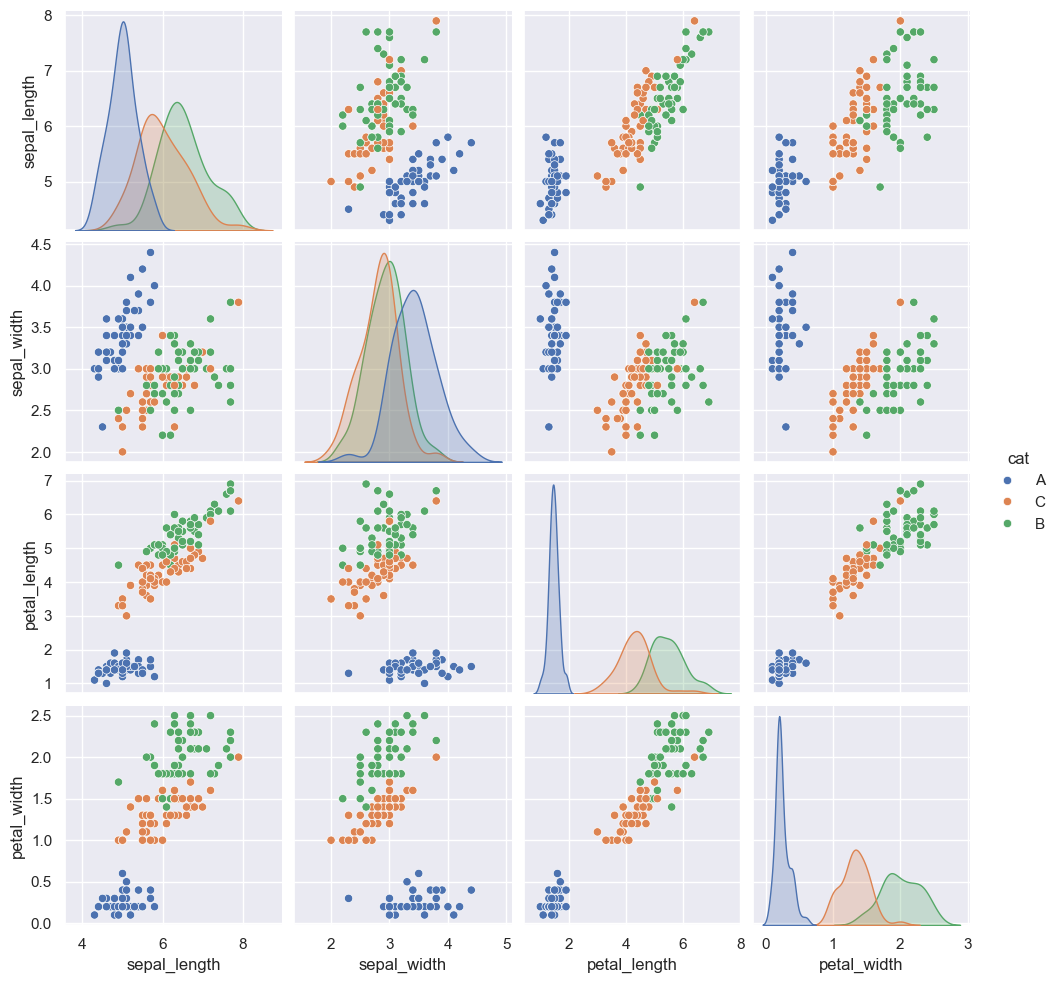

In [20]:
sns.pairplot(R, hue='cat');